# Projeto Híbrido de Filtros FIR + Redes Neurais
### Disciplina: PDS
Ricardo Ferreira dos Santos Silva


## 1. Introdução
O que são Filtros FIR?

Filtros FIR (Finite Impulse Response) são filtros digitais que possuem uma resposta ao impulso finita. Isso significa que se aplicar um impulso na entrada do filtro, a saída do filtro será uma sequência de valores que eventualmente se tornam zero depois de um tempo finito.


- Sempre estáveis.

- Possuem fase linear (importante em aplicações de áudio e comunicações).

- São definidos pelos seus coeficientes (ou taps).

# Projetar filtros FIR envolve escolher parâmetros:

- Frequência de corte (fc).

- Largura de transição (Δf).

- Atenuação na banda de rejeição (As).

- Número de coeficientes (ordem/taps).

Cada escolha afeta o desempenho e o custo computacional do filtro.


# Projeto

Usar Redes Neurais para auxiliar no projeto de filtros FIR.

A rede aprende a prever os parâmetros ideais do filtro a partir de especificações.

Depois, combinamos isso com métodos clássicos (Scipy) para gerar os coeficientes finais.

- Gerar um dataset de filtros FIR (parâmetros + coeficientes).

- Treinar uma rede neural (ParamNet) para prever parâmetros de filtros.

- Integrar predição + Forma clássica, formando um modelo híbrido.

- Validar os filtros previstos com os filtros projetados diretamente pelo Scipy.

## 2. Geração dos Dados
- Cada filtro é descrito por:
  - fc (freq. de corte), trans (largura de transição),
  - Rp (ripple), As (atenuação), ordem (número de taps),
  - tipo (lowpass/highpass).
- Salvamos em `fir_dataset.npz` para treinar a rede.


In [1]:
import os
import numpy as np  
from scipy import signal 

def sample_spec(): 
    """Gera especificações válidas para filtros lowpass ou highpass (normalizadas, fs=1)."""
    fcut = np.random.uniform(0.02, 0.45)  # Frequência de corte
    trans = 10**np.random.uniform(np.log10(0.005), np.log10(0.12))  # largura da banda de transição (log-uniforme)
    Rp = np.random.uniform(0.01, 1.0)  # ripple na banda de passagem dB
    As = 10**np.random.uniform(np.log10(30), np.log10(100))  # atenuação na banda de rejeição dB 
    order = np.random.randint(8, 256)  # ordem do filtro
    ftype = np.random.choice(["lowpass", "highpass"]) # tipo de filtro, escolhido aleatoriamente como "lowpass" ou "highpass".
    
    return {'type': ftype, 'fc': fcut, 'trans': trans, 'Rp': Rp, 'As': As, 'order': order}

In [2]:
def is_valid_spec(spec):
    """Aplica restrições para specs ruins."""
    fc, trans, Rp, As, order = spec['fc'], spec['trans'], spec['Rp'], spec['As'], spec['order']
    
    if fc + trans >= 0.5: # garante que a banda de transição não ultrapasse a frequência de Nyquist (0.5 para fs=1)
        return False
    if trans < 0.005: # rejeita bandas de transição muito estreitas que são difíceis de implementar
        return False
    if As < 20: # rejeita filtros com atenuação na banda de rejeição menor que 20 dB
        return False
    return True

In [3]:
"""Projeta um filtro FIR com base nas especificações fornecidas, usando o algoritmo remez ou firwin (método baseado em janela)."""

def design_fir(spec):
    L = spec['order']  # número de taps
    fc = spec['fc']
    trans = spec['trans']
    ftype = spec['type']

    try:
        if ftype == "lowpass":
            bands = [0, fc, fc+trans, 0.5] # define a banda de passagem (0 a fc) e a banda de rejeição (fc+trans a 0.5).
            desired = [1, 0] # ganho de 1 na banda de passagem e 0 na banda de rejeição.
        else:  # highpass
            bands = [0, fc-trans, fc, 0.5]
            desired = [0, 1]
        h = signal.remez(L, bands, desired, fs=1.0)
    except Exception:
        # fallback
        pass_zero = True if ftype == "lowpass" else False
        h = signal.firwin(L, fc, window='hamming', fs=1.0, pass_zero=pass_zero)
    return h # coeficientes do filtro

In [4]:
"""
    Gera um conjunto de dados com n_samples filtros FIR, 
    cada um com especificações aleatórias e seus coeficientes correspondentes, 
    salva em um arquivo comprimido NumPy.
"""

def generate_dataset(n_samples=50000, Nmax=256, out_fname='fir_dataset.npz'):
    specs = [] # armazenar as especificações dos filtros.
    coefs = np.zeros((n_samples, Nmax), dtype=np.float32) # armazenar os coeficientes dos filtros
    orders = np.zeros(n_samples, dtype=np.int32) # armazenar a ordem

    i = 0
    attempts = 0
    while i < n_samples: # continua até que seja gerado o número de filtros especificados.
        attempts += 1
        s = sample_spec()
        if not is_valid_spec(s):
            continue
        
        try:
            h = design_fir(s)
        except Exception:
            continue
        
        L = len(h)
        
        coefs[i, :L] = h # armazena os coeficientes do filtro
        type_flag = 0 if s['type'] == "lowpass" else 1 # tipo de filtro (0 para passa-baixa, 1 para passa-alta).
        specs.append([s['fc'], s['trans'], s['Rp'], s['As'], L, type_flag]) # armazena a especificação na lista specs
        orders[i] = L 
        i += 1

    specs = np.array(specs, dtype=np.float32)
    full_path = os.path.abspath(out_fname)
    np.savez_compressed(out_fname, specs=specs, coefs=coefs, orders=orders)
    print(f"Salvo em: {full_path}")
    print(f"Taxa de descarte: {(attempts-n_samples)/attempts:.2%}")

generate_dataset(n_samples=50000, Nmax=256, out_fname='fir_dataset.npz')

Salvo em: c:\Users\Pichau\Documents\GitHub\FIR-Filters-with-Neural-Networks\fir_dataset.npz
Taxa de descarte: 3.35%


## O Modelo ParamNet

- O ParamNet é uma rede neural simples (do tipo MLP – Multilayer Perceptron) que funciona como um tradutor automático:

-  projetada para mapear especificações de filtros para os parâmetros do filtro FIR em um espaço padronizado.

Em outras palavras:

"A rede aprende a traduzir uma descrição do filtro (Frequência de corte, Largura da transição, Atenuação, ordem) em parâmetros ajustados."

# Arquitetura

- A rede é formada por camadas densas (totalmente conectadas).

- Cada camada aplica uma transformação linear + função Re

- Uso de Dropout para regularização, que ajuda a rede a não “decorar” os dados.

Arquitetura usada no projeto:

- Entrada: 6 dimensões (as especificações)

- Camadas escondidas: [256, 256, 128] neurônios

- Saída: 6 dimensões (os parâmetros ajustados)

In [7]:
import torch.nn as nn
import torch

# Define a classe ParamNet, que herda a classe base do PyTorch para modelos de redes neurais
class ParamNet(nn.Module):
    # Construtor da classe, define os parâmetros iniciais da rede
    # in_dim: dimensão da entrada (número de características, padrão é 6)
    # hidden: tupla com os tamanhos das camadas ocultas (padrão é (256, 256, 128))
    # dropout: probabilidade de dropout para regularização (padrão é 0.1, ou 10%)
    def __init__(self, in_dim=6, hidden=(256,256,128), dropout=0.1):
        # Chama o construtor da classe (nn.Module) para inicializar o módulo corretamente
        super().__init__()
        
        # lista para armazenar as camadas da rede
        layers = []
        # Inicializa prev com a dimensão de entrada (in_dim), que será usada como entrada da primeira camada
        prev = in_dim
        
        # Itera sobre os tamanhos das camadas ocultas
        for h in hidden:
            # adiciona uma camada linear que transforma de prev para h neurônios
            layers += [nn.Linear(prev, h)]
            # adiciona uma ativação ReLU (f(x) = max(0, x)) para introduzir não-linearidade
            # inplace=True modifica a entrada diretamente para economizar memória
            layers += [nn.ReLU(inplace=True)]
            # Se dropout for maior que 0, adiciona uma camada de dropout para regularização
            # Dropout zera aleatoriamente uma fração (dropout) das entradas durante o treinamento
            if dropout > 0:
                layers += [nn.Dropout(dropout)]
            # Atualiza prev para o tamanho da camada atual (h), que será a entrada da próxima camada
            prev = h
        
        # Adiciona a camada de saída, que mapeia da última camada oculta (prev) para 6 unidades
        layers += [nn.Linear(prev, 6)]  # Saída: parâmetros
        
        # Cria um contêiner nn.Sequential que encadeia todas as camadas na ordem definida
        # *layers desempacota a lista de camadas para o construtor de nn.Sequential
        self.net = nn.Sequential(*layers)
    
    # método forward que especifica como os dados fluem pela rede
    # x: tensor de entrada
    def forward(self, x):
        # Passa a entrada x pela sequência de camadas definida em self.net
        # O tensor passa por cada camada (lineares, ReLU, dropout) e retorna a saída final
        return self.net(x)

ModuleNotFoundError: No module named 'torch'

# Papel do ParamNet

Atua como um tradutor inteligente:

- O usuário pede um filtro com certas características.

- A rede prevê os parâmetros ajustados que melhor atendem às restrições.

- O Scipy então sintetiza o filtro final.


Quando o usuário pede um filtro, ele dá especificações ideais, por exemplo:

Um filtro passa-baixa com:

- Frequência de corte = 1 kHz

- banda de transição = 200 Hz

- Atenuação na banda de rejeição = 60 dB

- Ordem = 128 taps


A rede otimiza automaticamente os parâmetros que o usuário fornece, encontrando uma versão que respeita o design do filtro desejado entregando specs otimizados que ainda atendam ao pedido original.

In [1]:
# --- Imports ---
import numpy as np
import matplotlib.pyplot as plt
from hybrid_predict import load_paramnet, predict_fir_from_specs
from scipy import signal
import time

# --- Funções auxiliares ---
def compute_beta(As):
    if As > 50:
        return 0.1102 * (As - 8.7)
    elif As > 21:
        return 0.5842 * (As - 21)**0.4 + 0.07886 * (As - 21)
    else:
        return 0.0

def design_filter(fc, trans, Rp, As, order, ftype="lowpass", method="firwin"):
    """Projeto FIR clássico (lowpass / highpass)"""
    try:
        if method == "firwin":
            if ftype == "highpass" and order % 2 == 0:
                order += 1  # precisa ser ímpar p/ highpass
            taps = signal.firwin(
                order, cutoff=fc,
                window=("kaiser", compute_beta(As)),
                fs=1.0, pass_zero=(ftype == "lowpass")
            )
        elif method == "remez":
            if ftype == "lowpass":
                bands, desired = [0, fc, fc+trans, 0.5], [1, 0]
            else:
                bands, desired = [0, fc-trans, fc, 0.5], [0, 1]
            weights = [1/(10**(-Rp/20)), 1/(10**(-As/20))]
            taps = signal.remez(order, bands, desired, weight=weights, fs=1.0)
        return taps
    except Exception as e:
        print(f"Erro no design: {e}")
        return None

def compute_metrics(h_pred, h_design, fc, trans, n_fft=2048):
    min_len = min(len(h_pred), len(h_design))
    h_pred, h_design = h_pred[:min_len], h_design[:min_len]
    w, H_pred = signal.freqz(h_pred, worN=n_fft, fs=1.0)
    _, H_des  = signal.freqz(h_design, worN=n_fft, fs=1.0)
    H_pred_db = 20*np.log10(np.maximum(np.abs(H_pred), 1e-10))
    H_des_db  = 20*np.log10(np.maximum(np.abs(H_des), 1e-10))
    passband_mask = w <= fc
    stopband_mask = w >= (fc + trans)
    return {
        "mae_passband": np.mean(np.abs(H_pred_db[passband_mask] - H_des_db[passband_mask])),
        "mae_stopband": np.mean(np.abs(H_pred_db[stopband_mask] - H_des_db[stopband_mask])),
        "correlation":  np.corrcoef(h_pred, h_design)[0,1],
        "erle": 10*np.log10(np.sum(h_design**2) / np.sum((h_pred-h_design)**2 + 1e-10))
    }

def plot_comparison(h_pred, h_design, specs, n_fft=2048):
    fig, axes = plt.subplots(2,2,figsize=(15,10))
    w, H_pred = signal.freqz(h_pred, worN=n_fft, fs=1.0)
    _, H_des  = signal.freqz(h_design, worN=n_fft, fs=1.0)
    H_pred_db, H_des_db = 20*np.log10(np.maximum(np.abs(H_pred),1e-10)), 20*np.log10(np.maximum(np.abs(H_des),1e-10))
    
    # Magnitude
    axes[0,0].plot(w,H_des_db,label="Scipy",lw=2)
    axes[0,0].plot(w,H_pred_db,"--",label="Predição NN")
    axes[0,0].set(title="Magnitude",xlabel="Frequência",ylabel="dB"); axes[0,0].legend(); axes[0,0].grid(True,alpha=0.3)
    # Fase
    axes[0,1].plot(w,np.unwrap(np.angle(H_des)),"--",label="Scipy")
    axes[0,1].plot(w,np.unwrap(np.angle(H_pred)),label="Predição NN")
    axes[0,1].set(title="Fase",xlabel="Frequência",ylabel="radianos"); axes[0,1].legend(); axes[0,1].grid(True,alpha=0.3)
    # Coefs
    axes[1,0].stem(h_design,linefmt="C0-",markerfmt="C0o",basefmt="k-",label="Scipy")
    axes[1,0].stem(h_pred,linefmt="C1--",markerfmt="C1x",basefmt="k-",label="NN")
    axes[1,0].set(title="Coeficientes FIR",xlabel="n",ylabel="amplitude"); axes[1,0].legend(); axes[1,0].grid(True,alpha=0.3)
    # Erro
    axes[1,1].plot(w,H_pred_db-H_des_db,"r-")
    axes[1,1].axhline(0,color="k",ls="--",alpha=0.5)
    axes[1,1].set(title="Erro em Magnitude",xlabel="Frequência",ylabel="Erro (dB)"); axes[1,1].grid(True,alpha=0.3)
    
    plt.suptitle(f"Comparação FIR {specs['type']} | fc={specs['fc']}, trans={specs['trans']}, ordem={specs['order']}")
    plt.show()


Métricas: {'mae_passband': np.float64(6.12648946862131), 'mae_stopband': np.float64(0.003085038361203458), 'correlation': np.float64(-0.12657851180998275), 'erle': np.float64(-3.552425301559458)} | Tempo inferência: 0.004000186920166016 s


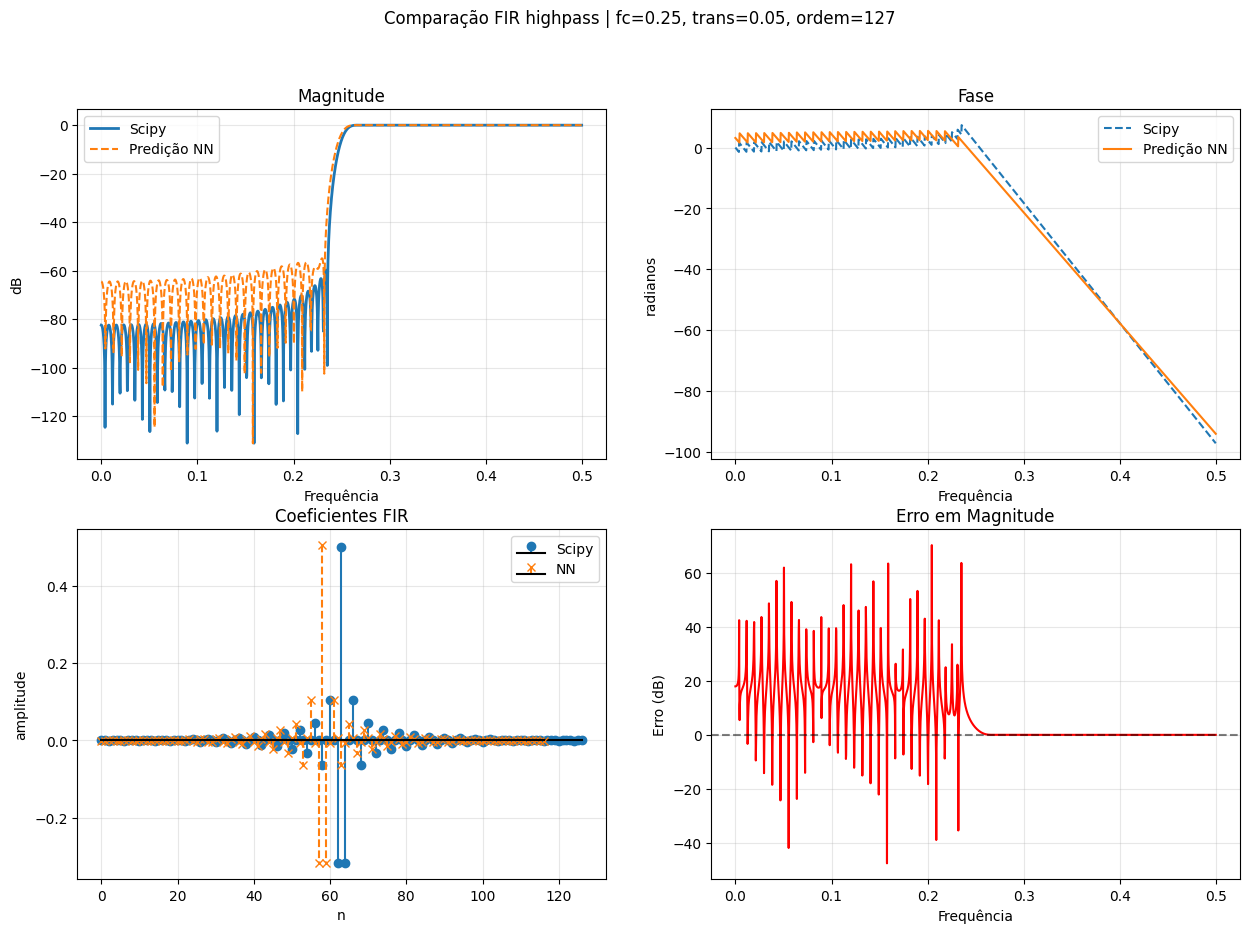

In [2]:
# Escolher as specs
fc, trans, Rp, As, order, ftype, method = 0.25, 0.05, 1.0, 60.0, 127, "highpass", "firwin"

# Carregar modelo
model, t_scaler, device = load_paramnet("checkpoints_hybrid/best_paramnet.pth")

# Montar entrada para a rede
type_val = 0 if ftype=="lowpass" else 1
spec = np.array([[fc, trans, Rp, As, order, type_val]], dtype=np.float32)

# Predição
start = time.time()
coefs_list, params = predict_fir_from_specs(spec, model, t_scaler, device=device, method=method)
h_pred = coefs_list[0]

# Design clássico
h_design = design_filter(fc, trans, Rp, As, order, ftype=ftype, method=method)

# Métricas
metrics = compute_metrics(h_pred, h_design, fc, trans)
print("Métricas:", metrics, "| Tempo inferência:", time.time()-start,"s")

# Plots
plot_comparison(h_pred, h_design, {"fc":fc,"trans":trans,"Rp":Rp,"As":As,"order":order,"type":ftype})


In [ ]:
from ipywidgets import interact, FloatSlider, IntSlider, Dropdown
# -------------------------
# Carregar modelo
# -------------------------
model, t_scaler, device = load_paramnet("checkpoints_hybrid/best_paramnet.pth")

# -------------------------
# Função interativa
# -------------------------
def interactive_prediction(fc=0.25, trans=0.05, Rp=1.0, As=60.0, order=127, ftype="lowpass", method="firwin"):
    type_val = 0 if ftype=="lowpass" else 1
    spec = np.array([[fc, trans, Rp, As, order, type_val]], dtype=np.float32)
    
    start = time.time()
    coefs_list, params = predict_fir_from_specs(spec, model, t_scaler, device=device, method=method)
    h_pred = coefs_list[0]
    
    h_design = design_filter(fc, trans, Rp, As, order, ftype=ftype, method=method)
    if h_design is None:
        print("Erro no design do filtro de referência")
        return
    
    print(f"Tempo de inferência: {time.time()-start:.4f}s")
    plot_comparison(h_pred, h_design, {"fc":fc,"trans":trans,"Rp":Rp,"As":As,"order":order,"type":ftype})

# -------------------------
# Sliders e dropdowns
# -------------------------
interact(
    interactive_prediction,
    fc=FloatSlider(min=0.05, max=0.45, step=0.01, value=0.25, description="fc"),
    trans=FloatSlider(min=0.01, max=0.2, step=0.01, value=0.05, description="Transição"),
    Rp=FloatSlider(min=0.1, max=3.0, step=0.1, value=1.0, description="Ripple"),
    As=FloatSlider(min=20, max=100, step=5, value=60.0, description="Atenuação"),
    order=IntSlider(min=31, max=255, step=2, value=127, description="Ordem"),
    ftype=Dropdown(options=["lowpass", "highpass"], value="lowpass", description="Tipo"),
    method=Dropdown(options=["firwin", "remez"], value="firwin", description="Método")
);


interactive(children=(FloatSlider(value=0.25, description='fc', max=0.45, min=0.05, step=0.01), FloatSlider(va…